# Clustering and Viz Experimentation

In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools

from new_classifier_utilities import *

### importing datasets

In [2]:
label_dataset = rasterio.open('/deep_data/NLCD/NLCD_2016_Land_Cover_L48_20190424.img')


l8_image_paths = [
    '/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
    '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined.tif'
]

s1_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined/aligned-LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined/aligned-LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined/aligned-LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined/aligned-LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined/aligned-LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_SAR.tif',
]

dem_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-77.7672_35.00779_-75.79042_36.58923__4500X4262_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-78.07896_33.69485_-76.14021_35.27466__4500X4248_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-76.14021_34.71847_-74.14865_36.318__4500X4408_ShowLogo_False_tiff_depth=32f.tiff',
]

ndvi_image_paths = [
    '/deep_data/ndvi_yearly/aligned-stackedImage_027012_20170907.tif'
]


landsat_datasets = []
for fp in l8_image_paths:
    landsat_datasets.append(rasterio.open(fp))
    
sentinel_datasets = []
for fp in s1_image_paths:
    sentinel_datasets.append(rasterio.open(fp))
    
dem_datasets = []
for fp in dem_image_paths:
    dem_datasets.append(rasterio.open(fp))

ndvi_datasets = []
for fp in ndvi_image_paths:
    ndvi_datasets.append(rasterio.open(fp))



### Class Dictionary and Confusion Matrix Function

In [3]:
class_names = dict((
(11, "Water"),
(12, "Snow/Ice"),
(21, "Open Space Developed"),
(22, "Low Intensity Developed"),
(23, "Medium Intensity Developed"),
(24, "High Intensity Developed"),
(31, "Barren Land"),
(41, "Deciduous Forest"),
(42, "Evergreen Forest"),
(43, "Mixed Forest"),
#(51, "Dwarf Scrub/Shrub - ALASKA"),
(52, "Scrub/Shrub"),
(71, "Grassland / Herbaceous"),
#(72, "Sedge / Herbaceous - ALASKA"),
#(73, "Lichen / Herbaceous - ALASKA"),
#(74, "Moss - ALASKA"),
(81, "Pasture/Hay"),
(82, "Cultivated Land"),
(90, "Woody Wetland"),
(95, "Emergent Herbaceous Wetlands"),
))

class_to_index = dict((
    (11, 0),
    (12, 1),
    (21, 2),
    (22, 3),
    (23, 4),
    (24, 5),
    (31, 6),
    (41, 7),
    (42, 8),
    (43, 9),
    (52, 10),
    (71, 11),
    (81, 12),
    (82, 13),
    (90, 14),
    (95, 15),
    ))

## Scikit-learn ML Approaches

### Prep Data for training and validation

In [4]:
# get pixel locations
train_pixels = gen_balanced_pixel_locations(image_datasets=landsat_datasets[:1], train_count=50000, 
                                            label_dataset=label_dataset, merge=False)


train_to_val_ratio = 0.8
train_px = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_px = train_pixels[int(len(train_pixels)*train_to_val_ratio):]

100%|██████████| 1/1 [00:47<00:00, 47.28s/it]


In [8]:
# get training data from those pixel locations
batch_size = len(train_px)
sk_im_batch, sk_label_batch = pixel_generator(landsat_datasets, sentinel_datasets, dem_datasets, ndvi_datasets, label_dataset, train_px, batch_size, merge=False)
print(sk_im_batch.shape, sk_label_batch.shape)

(37500, 22) (37500, 16)


In [9]:
batch_size = len(val_px)
sk_im_batch_val, sk_label_batch_val = pixel_generator(landsat_datasets, sentinel_datasets, dem_datasets, ndvi_datasets, label_dataset, val_px, batch_size, merge=False)
print(sk_im_batch_val.shape, sk_label_batch_val.shape)

(9375, 22) (9375, 16)


In [10]:
unique, counts = np.unique(np.argmax(sk_label_batch, axis=1), return_counts=True)
dict(zip(unique, counts))

{0: 3039,
 2: 2524,
 3: 2556,
 4: 2533,
 5: 2541,
 6: 892,
 7: 1410,
 8: 2886,
 9: 2184,
 10: 2962,
 11: 2459,
 12: 2277,
 13: 2946,
 14: 3108,
 15: 3183}

#### Spectral Signatures

In [11]:
classes

NameError: name 'classes' is not defined

In [12]:
index_to_class = {v: k for k, v in class_to_index.items()}

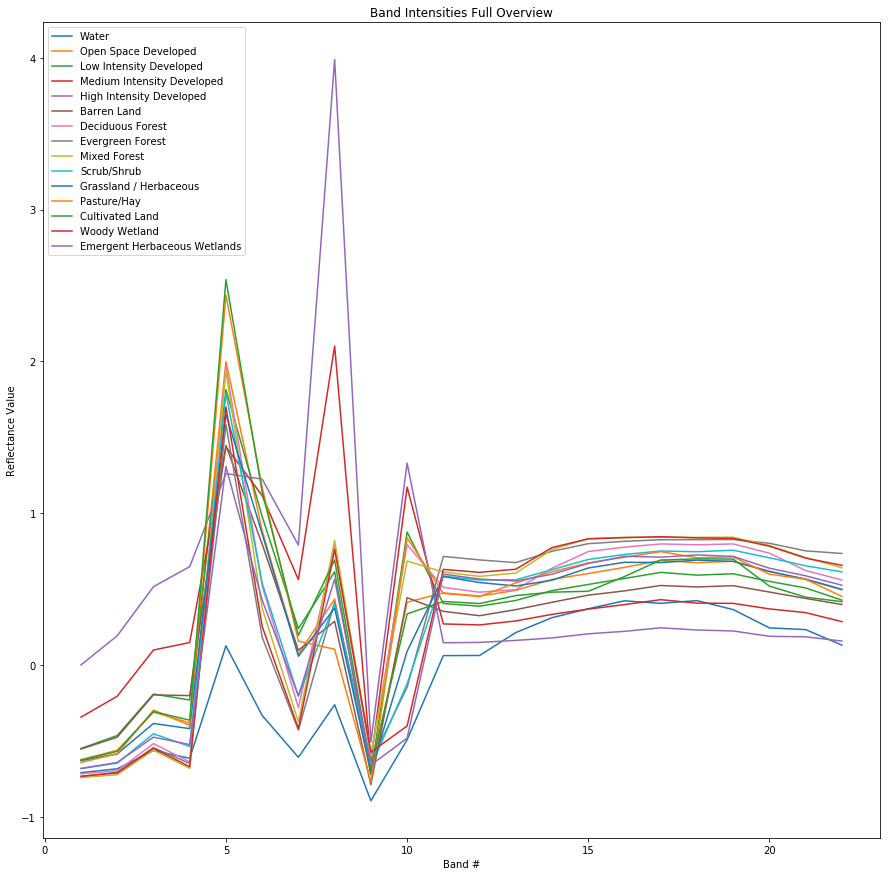

In [14]:
fig, ax = plt.subplots(1,1, figsize=[15,15])

# numbers 1-8
band_count = np.arange(1,23)

y = np.argmax(sk_label_batch, axis=1)
# adding NDVI and then concatenating it to the array
#X = np.concatenate((sk_im_batch, np.array([((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3]))]).T), axis=1)
X = sk_im_batch

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[index_to_class[class_type]])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


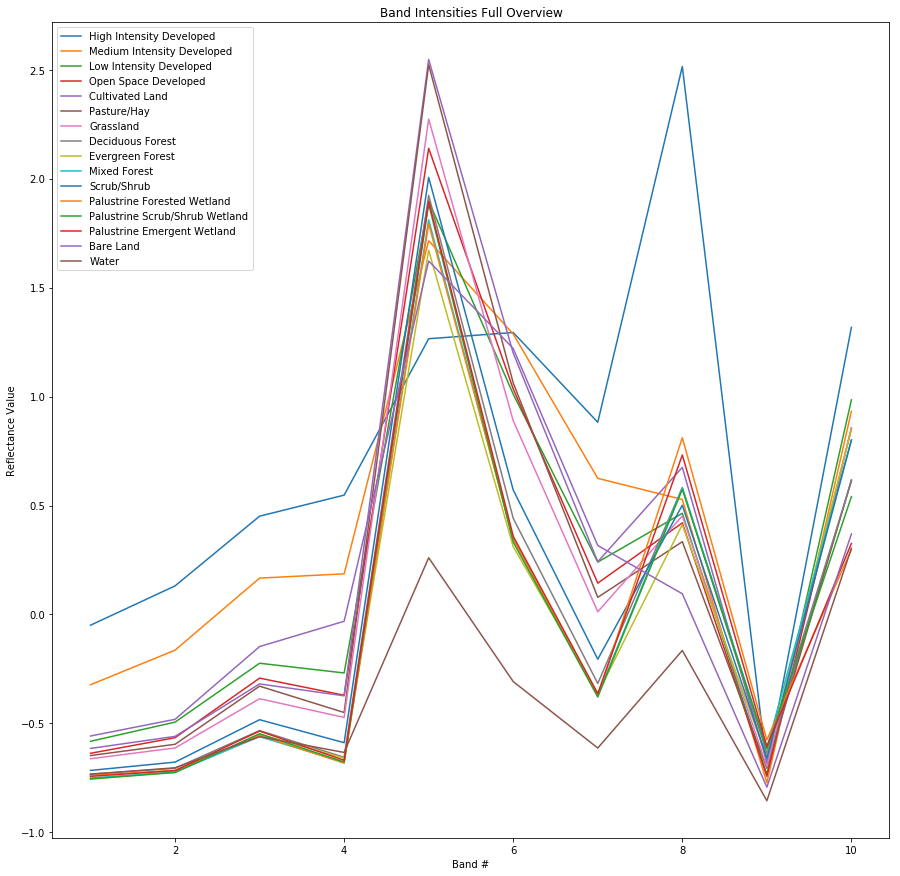

In [29]:
fig, ax = plt.subplots(1,1, figsize=[15,15])

# numbers 1-8
band_count = np.arange(1,11)

y = np.argmax(sk_label_batch, axis=1)
# adding NDVI and then concatenating it to the array
#X = np.concatenate((sk_im_batch, np.array([((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3]))]).T), axis=1)
X = sk_im_batch

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


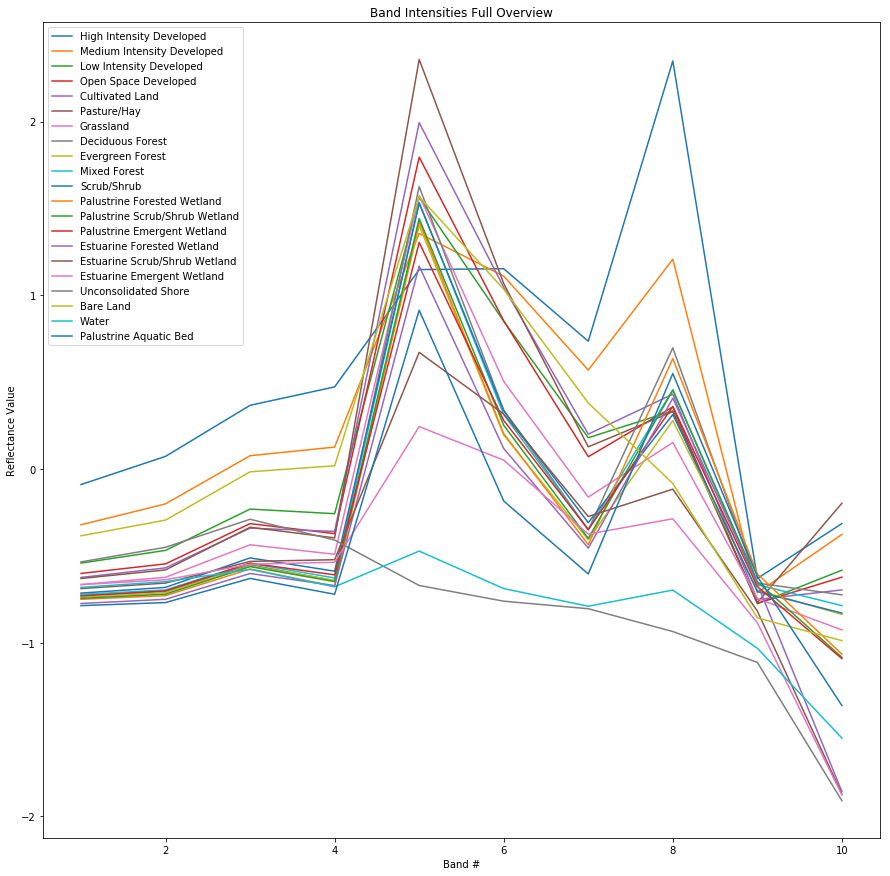

In [17]:
fig, ax = plt.subplots(1,1, figsize=[15,15])

# numbers 1-8
band_count = np.arange(1,11)

y = np.argmax(sk_label_batch, axis=1)
# adding NDVI and then concatenating it to the array
#X = np.concatenate((sk_im_batch, np.array([((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3]))]).T), axis=1)
X = sk_im_batch

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


In [28]:
np.argmax(sk_label_batch, axis=1)

array([ 2,  9, 13, ...,  2,  8,  6])

In [15]:
unique, counts = np.unique(np.argmax(sk_label_batch, axis=1), return_counts=True)
dict(zip(unique, counts))

{2: 3836,
 3: 3887,
 4: 3723,
 5: 3742,
 6: 3956,
 7: 2549,
 8: 3954,
 9: 3594,
 10: 4088,
 11: 4115,
 12: 4002,
 13: 4103,
 14: 3877,
 15: 3673,
 16: 270,
 17: 1942,
 18: 1913,
 19: 1851,
 20: 2849,
 21: 3666,
 22: 192}

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

spectral_sigs = []

#y = np.argmax(sk_label_batch, axis=1)
# adding NDVI and then concatenating it to the array
#X = np.concatenate((sk_im_batch, np.array([((sk_im_batch[:, 4] - sk_im_batch[:, 3]) / (sk_im_batch[:, 4] + sk_im_batch[:, 3]))]).T), axis=1)
classes = np.unique(y)

for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    spectral_sigs.append(band_intensity)
    ax.plot(band_count, band_intensity, label=class_names[index_to_class[class_type]])



In [16]:
classes

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [17]:
cosine_similarity(spectral_sigs, spectral_sigs).shape

(15, 15)

In [18]:
cos_sim = cosine_similarity(spectral_sigs, spectral_sigs)

In [19]:
cos_sim_top = np.argsort(-cos_sim)[:,:5]
cos_sim_top_score = np.sort(-cos_sim)[:,:5]

In [20]:
for i, top in enumerate(cos_sim_top):
    print('For ', class_names[index_to_class[classes[i]]], 'with', dict(zip(unique, counts))[classes[i]], 'the most similar are:')
    for index, class_index in enumerate(top):
        class_id = classes[class_index]
        score = round(cos_sim_top_score[i][index], 3)
        print('\t', class_names[index_to_class[class_id]], '-', class_id, '-', score)
    print('---')

For  Water with 3039 the most similar are:
	 Water - 0 - -1.0
	 Evergreen Forest - 8 - -0.715
	 Emergent Herbaceous Wetlands - 15 - -0.711
	 Woody Wetland - 14 - -0.696
	 Scrub/Shrub - 10 - -0.653
---
For  Open Space Developed with 2524 the most similar are:
	 Open Space Developed - 2 - -1.0
	 Barren Land - 6 - -0.991
	 Grassland / Herbaceous - 11 - -0.989
	 Pasture/Hay - 12 - -0.985
	 Cultivated Land - 13 - -0.984
---
For  Low Intensity Developed with 2556 the most similar are:
	 Low Intensity Developed - 3 - -1.0
	 Barren Land - 6 - -0.985
	 Open Space Developed - 2 - -0.98
	 Pasture/Hay - 12 - -0.98
	 Cultivated Land - 13 - -0.971
---
For  Medium Intensity Developed with 2533 the most similar are:
	 Medium Intensity Developed - 4 - -1.0
	 High Intensity Developed - 5 - -0.914
	 Low Intensity Developed - 3 - -0.852
	 Cultivated Land - 13 - -0.796
	 Barren Land - 6 - -0.776
---
For  High Intensity Developed with 2541 the most similar are:
	 High Intensity Developed - 5 - -1.0
	 Medium

#### PCA and Clustering

In [21]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca_result = pca.fit_transform(sk_im_batch)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

df = pd.DataFrame({'pca-one':pca_result[:,0],'pca-two':pca_result[:,1],'pca-three':pca_result[:,2], 'y' : np.argmax(sk_label_batch, axis=1)})

Explained variation per principal component: [0.66848121 0.13465339 0.07518143]


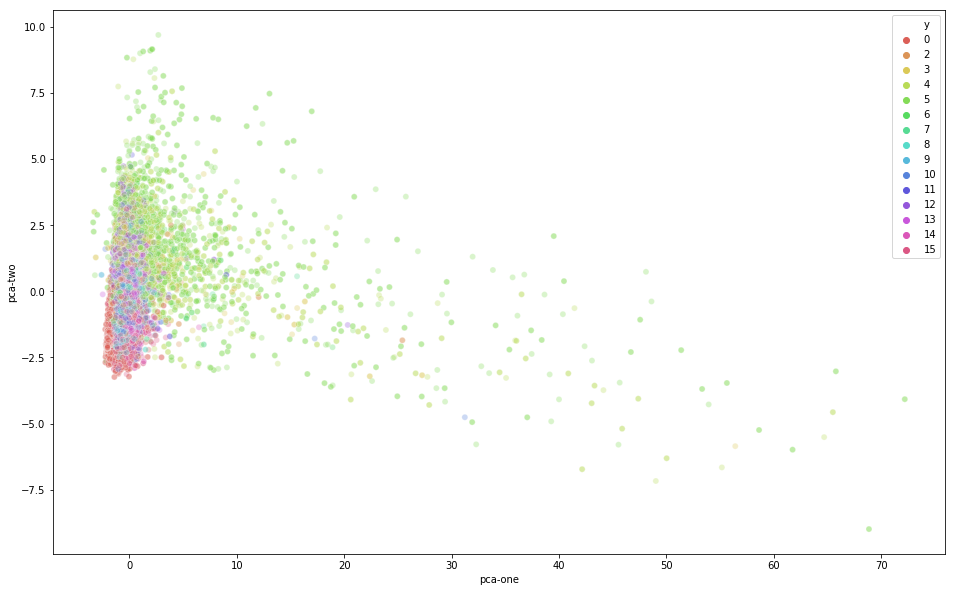

In [22]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(np.argmax(sk_label_batch, axis=1)))),
    data=df,
    legend="full",
    alpha=0.3
)

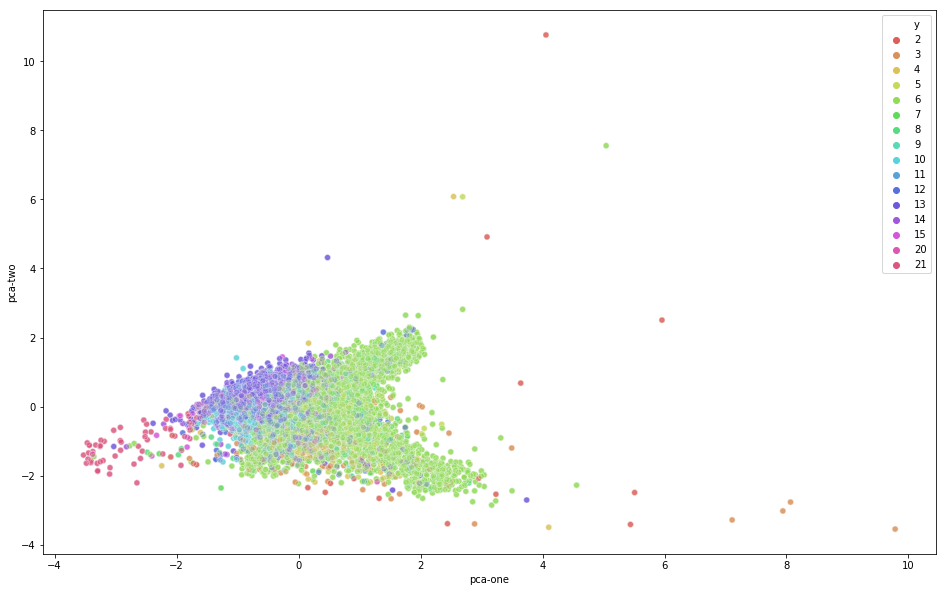

In [37]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(np.argmax(sk_label_batch, axis=1)))),
    data=df,
    legend="full",
    alpha=0.3
)

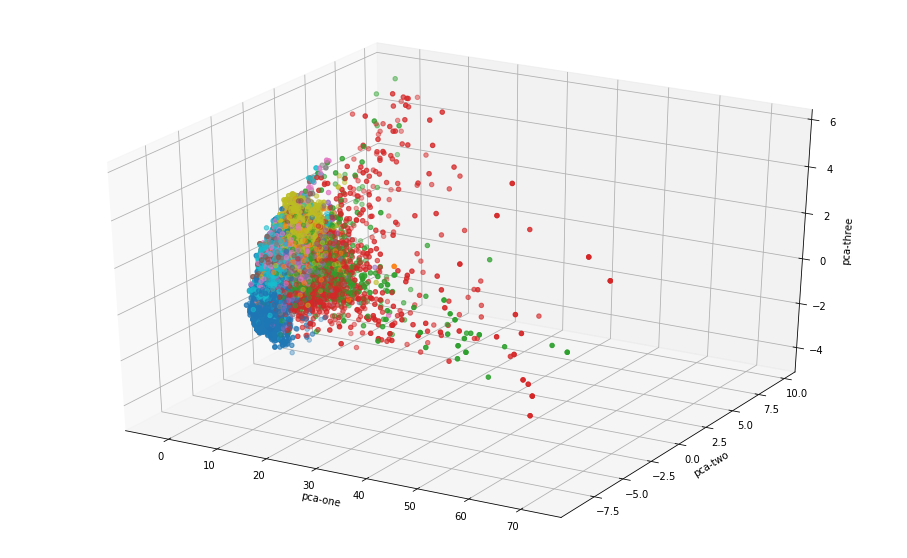

In [23]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

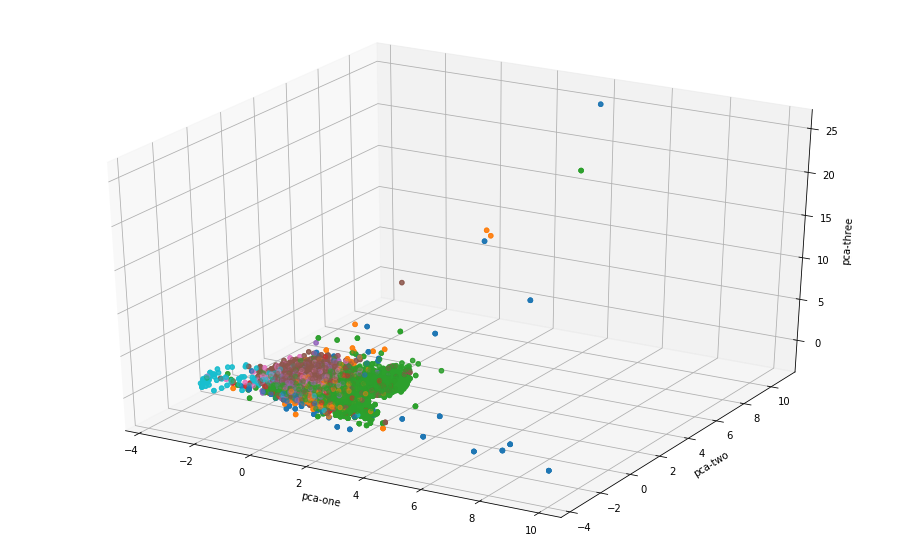

In [38]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [24]:
from time import time
from sklearn.manifold import TSNE

N = 10000
data_subset = sk_im_batch[:N, :]

time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 1.744s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.304147
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.555504
[t-SNE] KL divergence after 1000 iterations: 1.607269
t-SNE done! Time elapsed

In [25]:
df_subset = df.loc[:N-1,:].copy()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

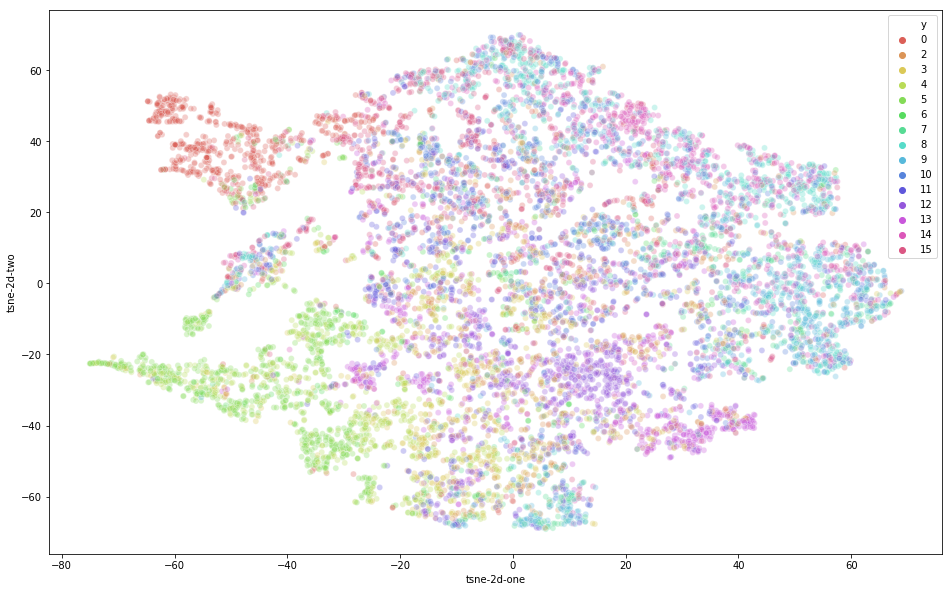

In [26]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(np.argmax(sk_label_batch, axis=1)))),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [12]:
# next setup a colormap for our map
colors = dict((
(0, (245,245,245, 255)), # Background
(1, (0,0,0)), # Unclassified (Cloud, Shadow, etc)
(2, (255,0,0)), # High Intensity Developed
(3, (255, 110, 51)), # Medium Intensity Developed
(4, (255, 162, 51)), # Low Intensity Developed
(5, (255, 162, 51)), # Open Space Developed
(6, (162, 89, 0)), # Cultivated Land
(7, (229, 221, 50)), # Pasture/Hay
(8, (185, 251, 96)), # Grassland
(9, (83, 144, 0)), # Deciduous Forest
(10, (13, 118, 0  )), # Evergreen Forest
(11, (62, 178, 49)), # Mixed Forest
(12, (100, 241, 125)), # Scrub/Shrub
(13, (68, 160, 85)), # Palustrine Forested Wetland
(14, (118, 192, 131)), # Palustrine Scrub/Shrub Wetland
(15, (188, 0, 211)), # Palustrine Emergent Wetland
(16, (188, 0, 211)), # Estuarine Forested Wetland
(17, (0, 0, 0)), # Estuarine Scrub/Shrub Wetland
(18, (172, 0, 191)), # Estuarine Emergent Wetland
(19, (159, 251, 255)), # Unconsolidated Shore 
(20, (172, 177, 68)), # Bare Land
(21, (29, 0, 189)), # Water
(22, (29, 0, 189)), # Palustrine Aquatic Bed
(23, (91, 199, 169)), # Estuarine Aquatic Bed
(24, (159, 251, 255)), # Tundra
(25, (159, 251, 255)), # Snow/Ice
))

n = 25

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)